In [ ]:
#pip install pmdarima

# CPI State Space Model Using ARIMA Method

[10 year US Government Bond Yields (long-term interest rate)](https://datahub.io/core/bond-yields-us-10y#readme)
***

### Steps for ARIMA implementation

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

### Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.The functions of use will are:
- ARIMA
- SARIMAX
- SEASONAL DECOMPOSE
- AUTO CORRELATION AND PARTIAL CORRELATION
- ACF AND PACF PLOT
- ADF FULLER - TEST
- KPSS

**Given the variety of tools, we can provide more accurate and useful predictions.**


In [14]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns

# Statsmodel for statistics
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import kpss

# Scientific computation
import scipy
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
#
#matplotlib.rcParams['figure.figsize'] = [8, 3]
#rcParams['figure.figsize'] = 18, 5
#rcParams['axes.spines.top'] = True
#rcParams['axes.spines.right'] = True
#rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
#rcParams['lines.linewidth'] = 2.5

%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)
print('Seaborn:', sns.__version__)

Matplotlib: 3.3.2
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2
Seaborn: 0.11.2


In [6]:
# read in cpi data
month = pd.read_csv('/Users/jasonrobinson/Documents/Projects/bls_project/data/cpi_avg_price_data.csv', parse_dates=['Year'], index_col='Year')

### Preprocessing

In [7]:
# Drop unncessary column
month = month.drop('Series ID', axis=1)
# Remove leaky data
month = month[:-2]

**Task**: Either use univariate or multivariate time series analysis.
If multivariate incorporate method to sum or average annual value for specific year

In [8]:
# Sum each row for univariate analysis
month['Cpi'] = month.sum(axis=1)


### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

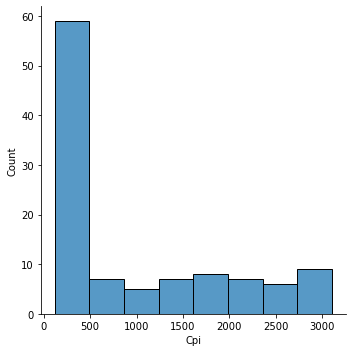

In [9]:
# Long right skewed distribution
sns.displot(data=month['Cpi']);

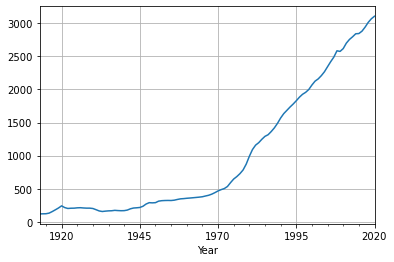

In [10]:
month['Cpi'].plot(x='CPI',grid=True);

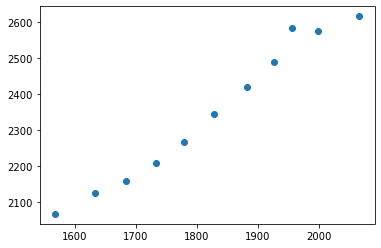

In [15]:
# Comparing 2 previous decades
plt.scatter(month['Cpi']['1990':'2000'], month['Cpi']['2000':'2010']);

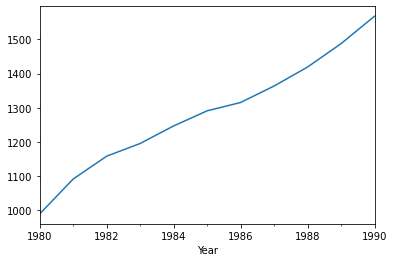

In [12]:
month['Cpi']['1980':'1990'].plot();


### Test for Stationarity

To be capable of applying an **ARIMA** method, we will first need to add stationarity. First let's confirm that our time series is not stationary. A few methods exist for this, but we will use the **KPSS** method.



In [ ]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month['Cpi'])

In [ ]:
from statsmodels.tsa.stattools import adfuller
# We acquire greater results through adfuller

def adf_test(month):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(month['Cpi'], autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    

    
adf_test(month)

In [ ]:
from statsmodels.tsa.stattools import kpss


def kpss_test(month):
    print("Results of KPSS Test:")
    kpsstest = kpss(month['Cpi'], regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    
    
kpss_test(month)

In [ ]:
# Reject the null hypothesis - test statistic actual pvalue smaller
sm.tsa.stattools.kpss(month['Cpi'], regression='ct')

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

seas_dcomp = seasonal_decompose(month['Cpi'],period=12,model='multiplicative')
seas_dcomp.plot();


### Make Series Stationary Using Log Transform


In [ ]:
#Transform the data from non-statinary to stationary
month_log = np.log(month['Cpi'])
month_diff = month_log.diff().dropna()

In [ ]:
# Check for stationarity
result = adfuller(month_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

In [ ]:
result_kpss_ct_log=kpss(month_diff,regression="ct")
print('Test Statistic: %f' % np.round(result_kpss_ct_log[0],2))
print('p-value: %f' %result_kpss_ct_log[1])
print('Critical values:')
for key, value in result_kpss_ct_log[3].items():
     print('\t%s: %.3f' %(key, value))

In [ ]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month_diff,label="after")
plt.plot(month['Cpi'],label="before")
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.legend()
plt.show()

In [ ]:
# Closer display
month_diff.plot()
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom='CPI')
plt.show();


### ACF/PACF

We can use these two functions to allow us to see at which level of lag is most significant towards the current value.


In [ ]:
# Autocorrelation
acf_month = acf(month['Cpi'])
acf_month

Nice, we can definitely tell the difference, but let's see if we can do better

Most important is ?

In [ ]:
plot_acf(month_diff, lags=12);

In [ ]:
# Partial autocorrelation
pacf_month = pacf(month['Cpi'])
pacf_month.round(2)

In [ ]:
plot_pacf(pacf_month, lags=12);

In [ ]:
# Visualize our plots
plt.title('Consumer Price Index with First-order difference', size=25)
plt.plot(month['Cpi'], label='CPI')
plt.plot(month_diff, label='First-order difference', color='orange')
plt.legend();


## Auto-ARIMA

In [ ]:
from pmdarima import auto_arima

month_fit = auto_arima(month_diff,start_p=0, d=0, start_q=0, 
                          max_p=3, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,n_fits = 50 )

month_fit.summary()


## SARIMAX

Using the SARIMAX model we will incorporate two orders. The first-order is p,d,q and the other is P,D,Q,m to accountfor seasonality.

In [ ]:
# Split data into train / test sets
train = month['Cpi'].iloc[:len(month['Cpi'])-3]
test = month['Cpi'].iloc[len(month['Cpi'])-3:] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train,
                order = (1, 1,0))
  
result = model.fit()
result.summary()

In [ ]:
start = len(train)
end = len(train) + len(test) + 10   #10 years into the future
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

## External code (COME BACK BUT NOT RELEVANT)

In [ ]:
import plotly.graph_objects as go

In [ ]:
#month['Cpi'] = np.where(month['Cpi'] > month['Cpi'].shift(1), 1, -1)


#fig = go.Figure(data=go.Scatter(
#                    y=np.exp(month['Cpi'].cumsum()),
#                    x=month.index,
#                    name="Cpi")
#               )
fig.add_trace(
        go.Scatter(
            y=np.log(month['Cpi']),
            x=month.index,
            name="Predictions")
    )
fig.update_layout(title=dict(text="Consumer Price Index",font=dict(size=18)),
                 legend=dict(font=dict(size=10)),
                  width=600,
                  height=500)

fig.update_xaxes(tickfont=dict(size=15, color="#434"))
fig.update_yaxes(tickfont=dict(size=15, color="#434"))

fig.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
# Mse - always non-negative and values close to zero are better
# Incorporates both the variance of the estimator and its bias.

rmse(test, predictions)
mean_squared_error(test, predictions)

In [ ]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);


In [ ]:
#from sklearn.model_selection import train_test_split
#train, val = train_test_split(month, test_size=len(test),  
#                              random_state=42)

In [ ]:
start = len(month_diff)
end = len(month['Cpi']) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);


### Alternate version


In [ ]:
mod = sm.tsa.statespace.SARIMAX(month_diff, order=(2,1,1), seasonal_order=(1,1,0,100), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

In [ ]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_ci